# Model Mortality with respect to heart

This project aims to model and predict the mortality rate in hospitals in patients by using a 1988 dataset of patient information from the Cleveland database, which can be found on [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci) and [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease). 

The project is divided into three separate Jupyter notebooks:

1. [Exploratory Data Analysis](https://github.com/melaniewalsh/heart-disease-prediction/blob/master/Exploratory-Data-Analysis.ipynb)
2. Modeling (below)
3. [Conclusions](https://github.com/melaniewalsh/heart-disease-prediction/blob/master/Conclusions.ipynb)

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [16]:
import numpy as np

In [17]:
import eli5
from eli5.sklearn import PermutationImportance

In [18]:
import shap

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
heart = pd.read_csv('heart.csv')

In [21]:
heart = heart.rename(columns={"cp": "chest_pain", "trestbps": "blood_pressure", "fbs": "blood_sugar", "ca": "vessels", "chol": "cholesterol"})

**Scale features**

In [22]:
standardScaler = StandardScaler()
columns_to_scale = ['age', 'blood_pressure', 'cholesterol', 'thalach', 'oldpeak']
heart[columns_to_scale] = standardScaler.fit_transform(heart[columns_to_scale])

**One-hot encode categorical features**

In [23]:
heart = pd.get_dummies(heart, columns = ['sex', 'chest_pain', 'blood_sugar', 'restecg', 'exang', 'slope', 'thal'], drop_first=True)

**Separate features from target labels (healthy or sick)**

In [24]:
labels = heart['target']
features = heart.drop(['target'], axis = 1)

**Split features and target labels into a training set and a test set** 

In [25]:
features_train , features_test, labels_train, labels_test = train_test_split(features, labels, test_size= 0.2, random_state=42)

# Random Forest

**Find the optimal number of decision trees for the Random Forest model (from a list of options)** 

[0.7704918032786885, 0.8688524590163934, 0.8688524590163934, 0.8524590163934426, 0.8688524590163934, 0.8524590163934426, 0.8524590163934426, 0.8524590163934426]


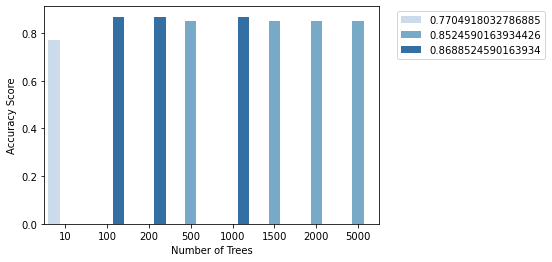

In [26]:
randomForest_scores = []
trees = [10, 100, 200, 500, 1000, 1500, 2000, 5000]
for x in trees:
    randomForest = RandomForestClassifier(n_estimators = x, random_state = 1, max_depth=1)
    randomForest.fit(features_train, labels_train)
    randomForest_scores.append(randomForest.score(features_test, labels_test))
print(randomForest_scores)

sns.barplot(trees, randomForest_scores, hue=randomForest_scores, palette='Blues')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Score')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

**Find the optimal max_depth for the Random Forest model (from a list of options)** 

[0.8688524590163934, 0.8524590163934426, 0.8360655737704918, 0.8360655737704918]


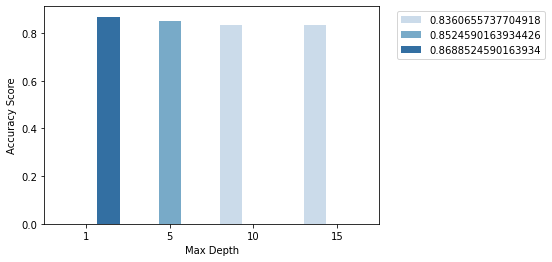

In [27]:
randomForest_scores = []
depth = [1, 5, 10, 15]
for x in depth:
    randomForest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth= x)
    randomForest.fit(features_train, labels_train)
    randomForest_scores.append(randomForest.score(features_test, labels_test))
print(randomForest_scores)

sns.barplot(depth, randomForest_scores, hue=randomForest_scores, palette='Blues')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

**Instantiate model with 1000 decision trees and max depth of 1 (optimal numbers based on iterated experiments above)**

In [28]:
randomForest = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_depth=1)

**Train the model on features and labels training data**

In [29]:
randomForest.fit(features_train, labels_train);

**Test the model on features and labels test data to assess its accuracy**

In [30]:
randomForest.score(features_test, labels_test)

score = round(randomForest.score(features_test,labels_test), 3) *100

print(f"Random Forest accuracy is {score}%")

Random Forest accuracy is 86.9%


**Feature ranking**

In [31]:
perm = PermutationImportance(randomForest, random_state=42).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.0295 ± 0.0382,vessels
0.0164 ± 0.0207,slope_1
0.0164 ± 0.0293,thal_3
0.0164 ± 0.0415,oldpeak
0.0098 ± 0.0161,sex_1
0.0033 ± 0.0131,chest_pain_2
0.0033 ± 0.0564,thal_2
0 ± 0.0000,chest_pain_1
0 ± 0.0000,blood_pressure
0 ± 0.0000,cholesterol


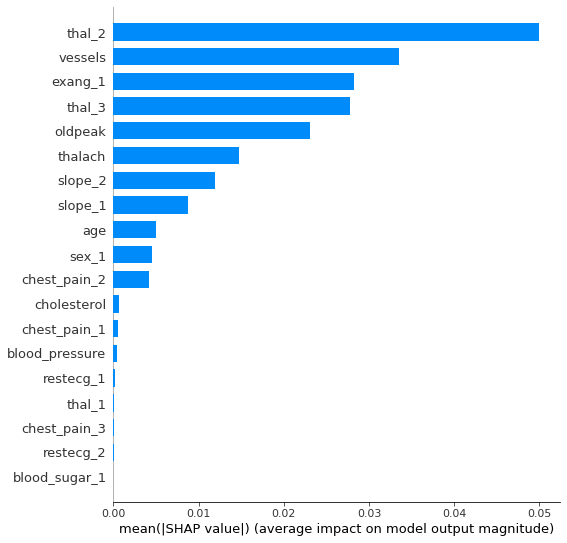

In [32]:
explainer = shap.TreeExplainer(randomForest)
shap_values = explainer.shap_values(features_test)

shap.summary_plot(shap_values[1], features_test, plot_type="bar")

**Confusion matrix**

Text(0.5, 1.0, 'Random Forest: Confusion Matrix')

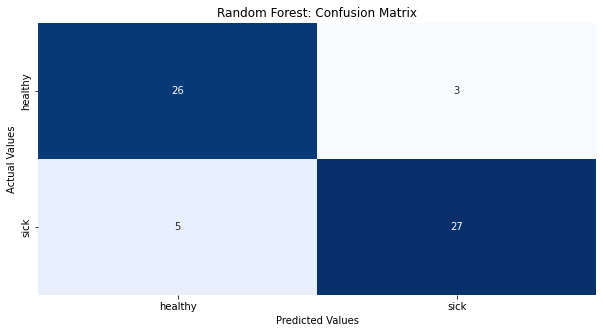

In [33]:
labels_predicted = randomForest.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest: Confusion Matrix')

# K Nearest Neighbors

In [34]:
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(features_train, labels_train)
prediction = knn.predict(features_test)


score = round(knn.score(features_test, labels_test), 3) *100
print(f"K Nearest Neighbors accuracy is {score}%")

K Nearest Neighbors accuracy is 82.0%


**Find the optimal k value (from 1-20)**

Max K Nearest Neighbors Accuracy is 90.16%
Best K is 23


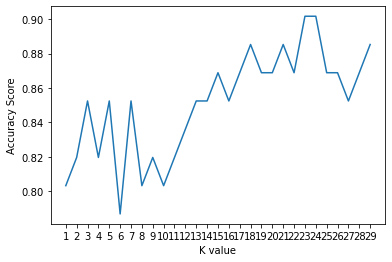

In [35]:
accuracyScores = []

for x in range(1,30):
    knn2 = KNeighborsClassifier(n_neighbors = x)
    knn2.fit(features_train, labels_train)
    accuracyScores.append(knn2.score(features_test, labels_test))
    
    
sns.lineplot(range(1,30), accuracyScores)
plt.xticks(np.arange(1,30,1))
plt.xlabel("K value")
plt.ylabel("Accuracy Score")


best_k = accuracyScores.index(max(accuracyScores)) + 1
max_score = round((max(accuracyScores) * 100), 2) 

print(f"Max K Nearest Neighbors Accuracy is {max_score}%")
print(f"Best K is {best_k}")

In [36]:
knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(features_train, labels_train)
prediction = knn.predict(features_test)


score = round(knn.score(features_test, labels_test), 3) *100
print(f"K Nearest Neighbors accuracy is {score}%")

K Nearest Neighbors accuracy is 90.2%


In [37]:
perm = PermutationImportance(knn, random_state=1).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.0852 ± 0.0700,vessels
0.0623 ± 0.0564,thalach
0.0361 ± 0.0321,thal_2
0.0295 ± 0.0131,slope_1
0.0295 ± 0.0321,exang_1
0.0262 ± 0.0491,blood_pressure
0.0230 ± 0.0161,chest_pain_3
0.0230 ± 0.0262,chest_pain_2
0.0197 ± 0.0321,thal_3
0.0197 ± 0.0245,slope_2


Text(0.5, 1.0, 'K Nearest Neighbors: Confusion Matrix')

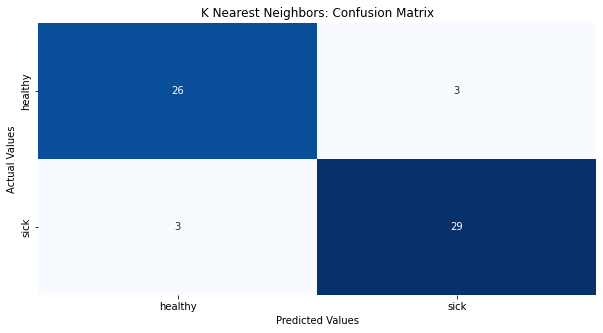

In [38]:
labels_predicted = knn.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('K Nearest Neighbors: Confusion Matrix')

In [39]:
print(classification_report(labels_test, labels_predicted, target_names = ['healthy', 'sick']))

              precision    recall  f1-score   support

     healthy       0.90      0.90      0.90        29
        sick       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



# Logistic Regression

In [40]:
logisticRegression = LogisticRegression( solver='lbfgs')
logisticRegression.fit(features_train,labels_train)
logisticRegression.score(features_test,labels_test)


score = round(logisticRegression.score(features_test,labels_test), 3) *100
print(f"Logistic Regression accuracy is {score}%")

Logistic Regression accuracy is 90.2%


In [41]:
perm = PermutationImportance(logisticRegression, random_state=1).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.0951 ± 0.0525,vessels
0.0590 ± 0.0262,chest_pain_2
0.0459 ± 0.0482,thal_3
0.0426 ± 0.0491,thalach
0.0361 ± 0.0482,oldpeak
0.0328 ± 0.0207,slope_2
0.0295 ± 0.0245,slope_1
0.0295 ± 0.0245,restecg_1
0.0230 ± 0.0262,chest_pain_3
0.0230 ± 0.0334,exang_1


Text(0.5, 1.0, 'Logistic Regression: Confusion Matrix')

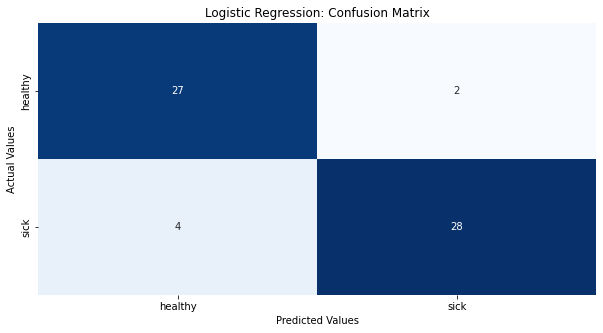

In [42]:
labels_predicted = logisticRegression.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression: Confusion Matrix')

In [43]:
labels_predicted = logisticRegression.predict(features_test)
print(classification_report(labels_test, labels_predicted, target_names = ['healthy', 'sick']))

              precision    recall  f1-score   support

     healthy       0.87      0.93      0.90        29
        sick       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



# Naive Bayes

In [44]:
nb = GaussianNB()
nb.fit(features_train, labels_train)
nb.score(features_test,labels_test)

score = round(nb.score(features_test,labels_test), 3) *100

print(f"Naive Bayes accuracy is {score}%")

Naive Bayes accuracy is 86.9%


Text(0.5, 1.0, 'Naive Bayes: Confusion Matrix')

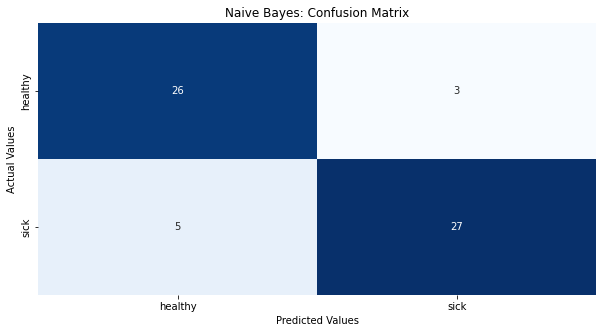

In [45]:
labels_predicted = nb.predict(features_test)
plt.subplots(figsize=(10,5))

conf_mat = confusion_matrix(labels_test, labels_predicted)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Naive Bayes: Confusion Matrix')